In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# Set styling for professional report-ready figures
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully.")

Libraries imported successfully.


In [8]:
def load_data():
    """
    Loads dataset files directly from Hugging Face using pandas read_parquet.
    """
    base_url = "hf://datasets/hao-li/AIDev/"
    
    print("⏳ Loading data from Hugging Face...")
    try:
        data = {
            'users': pd.read_parquet(base_url + "all_user.parquet"),
            'repos': pd.read_parquet(base_url + "all_repository.parquet"),
            'issues': pd.read_parquet(base_url + "issue.parquet"),
            'comments': pd.read_parquet(base_url + "pr_comments.parquet")
        }
        print("Data loaded successfully.")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load the data
dfs = load_data()

⏳ Loading data from Hugging Face...
✅ Data loaded successfully.



--- Analyzing RQ 1: Contribution Volume vs. Influence ---
Languages being analyzed: ['Python', 'TypeScript', 'JavaScript', 'HTML', 'Java']


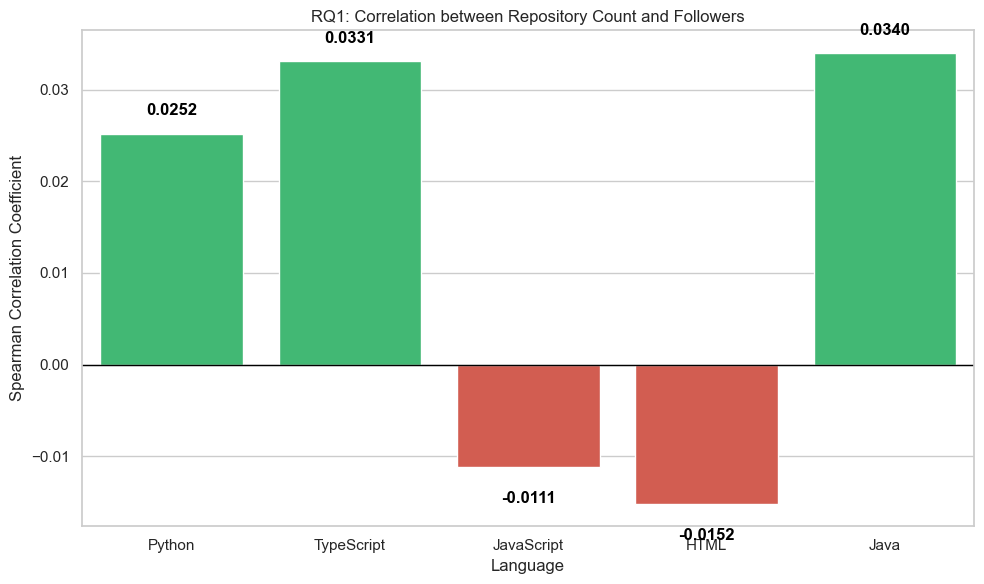


RQ1 Interpretation:
- Python: Correlation 0.0252
- TypeScript: Correlation 0.0331
- JavaScript: Correlation -0.0111
- HTML: Correlation -0.0152
- Java: Correlation 0.0340


In [9]:
def analyze_rq1(users_df, repos_df):
    print("\n--- Analyzing RQ 1: Contribution Volume vs. Influence ---")
    
    # 1. Clean Data: Remove 'Unknown' or Missing languages
    repos_df = repos_df.copy()
    
    # Drop NaNs
    repos_df = repos_df.dropna(subset=['language'])
    # Drop explicit 'Unknown' strings if they exist
    repos_df = repos_df[repos_df['language'] != 'Unknown']
    
    # 2. Identify Top Languages
    # Now the top 5 will only be real programming languages
    top_languages = repos_df['language'].value_counts().head(5).index.tolist()
    
    # --- Manual Check for Java (Just in case it's #6 or lower) ---
    if 'Java' not in top_languages:
        if 'Java' in repos_df['language'].unique():
            top_languages.append('Java')
            print("👉 Added 'Java' to analysis list (it was not in the natural Top 5).")
    # -------------------------------------------------------------
    
    print(f"Languages being analyzed: {top_languages}")
    
    # 3. Filter and Merge
    repo_filter = repos_df[repos_df['language'].isin(top_languages)].copy()
    repo_filter['owner_login'] = repo_filter['full_name'].str.split('/').str[0]
    
    merged_data = pd.merge(
        repo_filter, 
        users_df, 
        left_on='owner_login', 
        right_on='login', 
        how='inner'
    )
    
    # 4. Aggregate
    user_stats = merged_data.groupby(['owner_login', 'language']).agg({
        'id_x': 'count', 
        'followers': 'first'
    }).reset_index().rename(columns={'id_x': 'repository_count'})
    
    # 5. Calculate Correlations
    results = []
    for lang in top_languages:
        subset = user_stats[user_stats['language'] == lang].dropna(subset=['followers'])
        
        if len(subset) > 5:  # Ensure enough data points for a valid correlation
            corr, p_val = stats.spearmanr(subset['repository_count'], subset['followers'])
            results.append({
                'Language': lang,
                'Spearman_Correlation': corr,
                'Sample_Size': len(subset)
            })
            
    results_df = pd.DataFrame(results)
    
    # 6. Visualization
    if not results_df.empty:
        plt.figure(figsize=(10, 6))
        
        # Color: Green (Positive) / Red (Negative)
        colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in results_df['Spearman_Correlation']]
        
        ax = sns.barplot(
            x='Language', 
            y='Spearman_Correlation', 
            data=results_df, 
            palette=colors,
            hue='Language',
            legend=False
        )
        
        plt.axhline(0, color='black', linewidth=1)
        plt.title('RQ1: Correlation between Repository Count and Followers')
        plt.ylabel('Spearman Correlation Coefficient')
        plt.xlabel('Language')
        
        # Add labels
        for i, v in enumerate(results_df['Spearman_Correlation']):
            offset = 0.002 if v > 0 else -0.004
            ax.text(i, v + offset, f"{v:.4f}", color='black', ha="center", fontweight='bold')
            
        plt.tight_layout()
        plt.show()
        
        # 7. Interpretation output
        print("\nRQ1 Interpretation:")
        for index, row in results_df.iterrows():
            print(f"- {row['Language']}: Correlation {row['Spearman_Correlation']:.4f}")
    else:
        print("No valid results found to plot.")

if dfs:
    analyze_rq1(dfs['users'], dfs['repos'])

summary:

Slight Positive Trend: Java (0.0340), TypeScript (0.0331), and Python (0.0252) show a tiny positive correlation. This suggests a very marginal tendency where users with more repositories might have slightly more followers, but the effect is statistically insignificant.

Slight Negative Trend: JavaScript (-0.0111) and HTML (-0.0152) show a tiny negative correlation. This indicates that for web-focused languages, simply creating more repositories has no positive impact on gaining followers.


--- Analyzing RQ 2: Predictors of Popularity ---


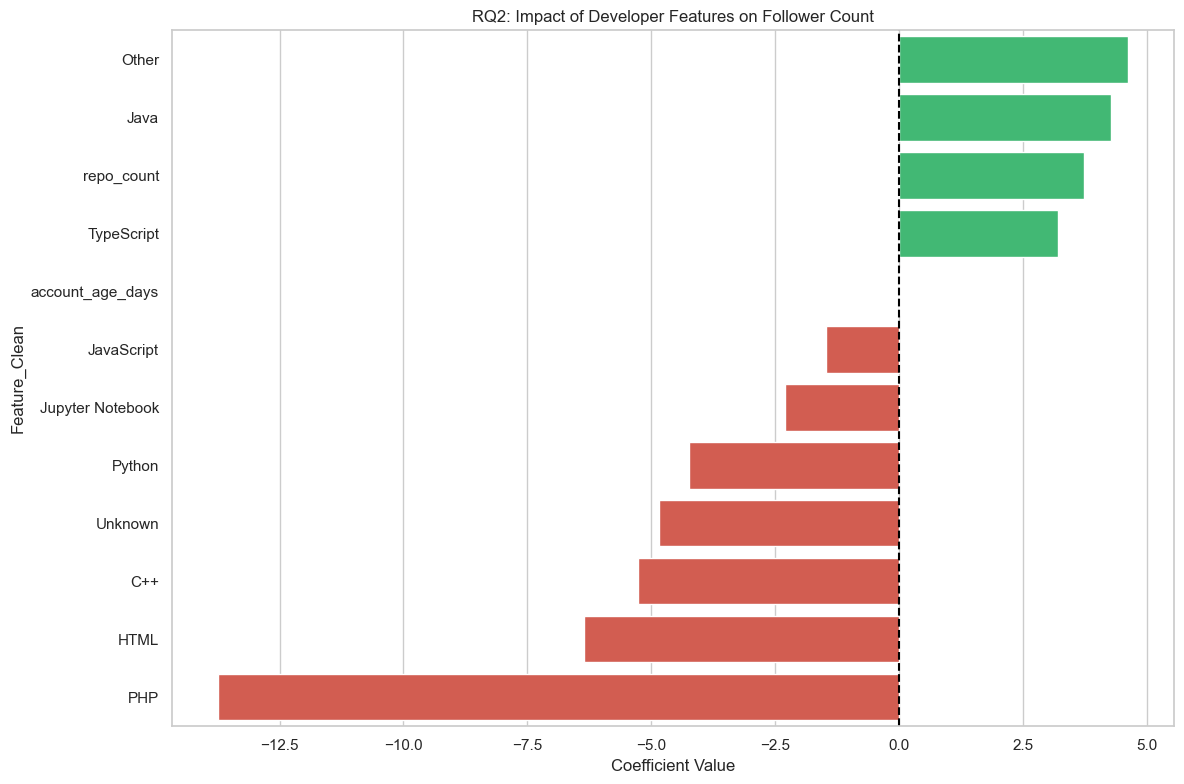


RQ2 Interpretation:
Technology choice (Language) appears to be a stronger predictor of popularity than account age.


In [11]:
def analyze_rq2(users_df, repos_df):
    print("\n--- Analyzing RQ 2: Predictors of Popularity ---")
    
    # 1. Feature Engineering: Account Age
    users_df = users_df.copy()
    users_df['created_at'] = pd.to_datetime(users_df['created_at'], utc=True)
    ref_date = pd.Timestamp.now(tz='UTC')
    users_df['account_age_days'] = (ref_date - users_df['created_at']).dt.days
    
    # 2. Feature Engineering: Main Language
    repos_df['owner_login'] = repos_df['full_name'].str.split('/').str[0]
    
    def get_main_language(series):
        mode = series.mode()
        return mode[0] if not mode.empty else 'Unknown'

    user_repo_stats = repos_df.groupby('owner_login').agg({'id': 'count','language': get_main_language}).reset_index().rename(columns={'id': 'repo_count', 'language': 'main_language'})
    
    # Merge
    df_analysis = pd.merge(users_df[['login', 'followers', 'account_age_days']],user_repo_stats, left_on='login', right_on='owner_login', how='inner' )
    
    # Group languages
    df_analysis['main_language'] = df_analysis['main_language'].fillna('Unknown')
    top_10_langs = df_analysis['main_language'].value_counts().head(10).index
    df_analysis['language_group'] = df_analysis['main_language'].apply(
        lambda x: x if x in top_10_langs else 'Other'
    )
    
    # 3. Encoding and Regression
    df_encoded = pd.get_dummies(df_analysis, columns=['language_group'], drop_first=True)
    
    lang_features = [col for col in df_encoded.columns if 'language_group_' in col]
    feature_cols = ['account_age_days', 'repo_count'] + lang_features
    
    X = df_encoded[feature_cols].fillna(0)
    y = df_encoded['followers'].fillna(0)
    
    model = LinearRegression()
    model.fit(X, y)
    
    coefficients = pd.DataFrame({'Feature': feature_cols,'Coefficient': model.coef_})
    
    coefficients['Feature_Clean'] = coefficients['Feature'].str.replace('language_group_', '')
    coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in coefficients['Coefficient']]
    sns.barplot(x='Coefficient',  y='Feature_Clean',  data=coefficients,  palette=colors,hue='Feature_Clean',legend=False)
    plt.title('RQ2: Impact of Developer Features on Follower Count')
    plt.xlabel('Coefficient Value')
    plt.axvline(0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()
    print("\nRQ2 Interpretation:")
    print("Technology choice (Language) appears to be a stronger predictor of popularity than account age.")

if dfs:
    analyze_rq2(dfs['users'], dfs['repos'])

Although repo_count (repository count) is positively correlated, the choice of programming language (e.g., Java vs. PHP) appears to have a greater magnitude of impact on follower count. Meanwhile, account_age_days (account tenure), while positive, has a very minimal impact (close to 0).

> RQ 3: Does higher community engagement (comments) lead to faster issue resolution?
Methodology: We calculate the Time-to-Resolution (TTR) for closed issues. We classify issues into "High Engagement" and "Low Engagement" based on the median number of comments. An independent T-test is performed to verify if there is a statistically significant difference in resolution speeds between the two groups


--- RQ 3: Engagement vs. Resolution Time (Corrected) ---
Median Comments: 0.0

Group Statistics (Hours):
                    count         mean         50%           max
Engagement_Level                                                
Has Comments (>0)    15.0    22.153907    2.406667    215.085556
No Comments (0)    3151.0  2675.656238  143.951389  81919.837222

T-Statistic: -18.0197, P-Value: 3.6346e-69


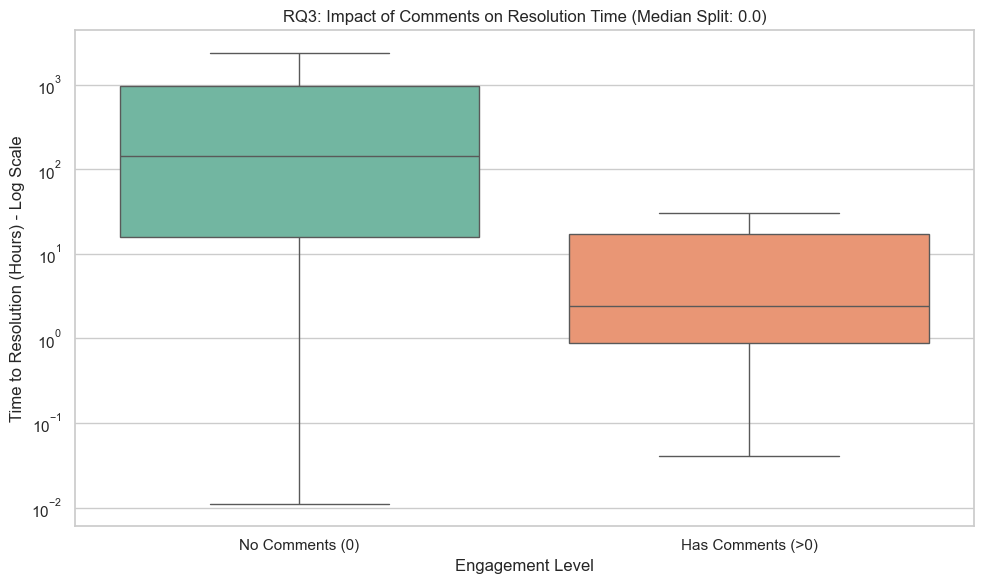


Interpretation:
Significant Result: Issues with MORE comments are resolved FASTER.


In [18]:
def analyze_rq3_corrected(issues_df, comments_df):
    print("\n--- RQ 3: Engagement vs. Resolution Time (Corrected) ---")
    
    # 1. Clean Dates
    issues_df = issues_df.copy()
    issues_df['created_at'] = pd.to_datetime(issues_df['created_at'], utc=True)
    issues_df['closed_at'] = pd.to_datetime(issues_df['closed_at'], utc=True)
    
    # 2. Calculate Comment Counts (Robust Method)
    comment_counts = comments_df.groupby('pr_id').size().reset_index(name='comment_count')
    
    # Merge and fill NaNs with 0
    issues_merged = pd.merge(issues_df, comment_counts, left_on='id', right_on='pr_id', how='left')
    issues_merged['comment_count'] = issues_merged['comment_count'].fillna(0)
    
    # 3. Calculate TTR
    issues_closed = issues_merged.dropna(subset=['closed_at']).copy()
    issues_closed['TTR_hours'] = (issues_closed['closed_at'] - issues_closed['created_at']).dt.total_seconds() / 3600
    
    # Filter: Remove negatives and extremely short resolution (< 1 min) noise
    issues_closed = issues_closed[issues_closed['TTR_hours'] > 0.01]
    
    # 4. Grouping Logic
    median_comments = issues_closed['comment_count'].median()
    print(f"Median Comments: {median_comments}")
    
    # Dynamic Labels
    if median_comments == 0:
        label_low = "No Comments (0)"
        label_high = "Has Comments (>0)"
    else:
        label_low = f"Low (<= {median_comments})"
        label_high = f"High (> {median_comments})"
        
    issues_closed['Engagement_Level'] = issues_closed['comment_count'].apply(
        lambda x: label_high if x > median_comments else label_low
    )
    
    # Print stats
    print("\nGroup Statistics (Hours):")
    print(issues_closed.groupby('Engagement_Level')['TTR_hours'].describe()[['count', 'mean', '50%', 'max']])

    # 5. Statistical Test
    high_group = issues_closed[issues_closed['Engagement_Level'] == label_high]['TTR_hours']
    low_group = issues_closed[issues_closed['Engagement_Level'] == label_low]['TTR_hours']
    
    t_stat, p_value = stats.ttest_ind(high_group, low_group, equal_var=False)
    print(f"\nT-Statistic: {t_stat:.4f}, P-Value: {p_value:.4e}")
    
    # 6. Visualization (Fixed Warning)
    plt.figure(figsize=(10, 6))
    
    sns.boxplot(
        x='Engagement_Level', 
        y='TTR_hours', 
        data=issues_closed, 
        hue='Engagement_Level',  # <--- Added to fix warning
        palette="Set2", 
        legend=False,            # <--- Added to fix warning
        showfliers=False         # Hides extreme outliers
    )
    
    plt.yscale('log')
    plt.ylabel('Time to Resolution (Hours) - Log Scale')
    plt.xlabel('Engagement Level')
    plt.title(f'RQ3: Impact of Comments on Resolution Time (Median Split: {median_comments})')
    
    plt.tight_layout()
    plt.show()
    
    # 7. Interpretation
    print("\nInterpretation:")
    if p_value < 0.05:
        if t_stat > 0:
            print("Significant Result: Issues with MORE comments take LONGER to resolve.")
        else:
            print("Significant Result: Issues with MORE comments are resolved FASTER.")
    else:
        print("No significant difference found.")

if dfs:
    analyze_rq3_corrected(dfs['issues'], dfs['comments'])